# Implementace backpropagace pro MLP

In [1]:
# Library tqdm is a useful tool for creating progress bars
from tqdm import trange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [2]:
def get_model_accuracy(model, inputs, labels):
    predictions = model.predict(inputs)
    predicted_classes = np.argmax(predictions, axis=-1)
    model_accuracy = accuracy_score(predicted_classes, labels)
    
    return model_accuracy

## MLP s backpropagací

In [3]:
def sigmoid(x):
    # Clip the values to prevent overflows
    x = x.clip(-5e2,5e2)
    
    return 1 / (1 + np.exp(-x))

Derivace sigmoid funkce je následovná: *($\sigma$(x))' = $\sigma$(x) \* (1 - $\sigma$(x))*

In [ ]:
class MultiLayerPerceptron:
    def __init__(self, layer_sizes, training_iterations=int(1e3), learning_rate=1e-2):
        self.layer_sizes = layer_sizes
        self.weights = []
        self.training_iterations = training_iterations
        self.learning_rate = learning_rate
        self.last_run_activations = None
        
        for (input_layer_size, output_layer_size) in zip(self.layer_sizes, self.layer_sizes[1:]):
           self.weights.append(np.random.normal(size=(input_layer_size + 1, output_layer_size)))
           
           
    def _add_ones(self, x):
        """ Add a column of ones for bias (the first row in the weight matrix represents the biases) """
        ones = np.ones(shape=(x.shape[0], 1))
        return np.concatenate([ones, x], axis=1)
    
    
    def predict(self, inputs):
        activations = np.array(inputs)
        self.last_run_activations = [activations]
        
        try:
            for layer in self.weights:
                extended_activations = self._add_ones(activations)
                linear_combination = np.dot(extended_activations, layer)
                activations = sigmoid(linear_combination)
                self.last_run_activations.append(activations)
                
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations
    
    
    def fit(self, inputs, labels):
        progress_bar = trange(self.training_iterations)
        for i in progress_bar:
            # Compute the NN's output
            self.predict(inputs)
            
            # Perform the backpropagation
            self._perform_backpropagation(labels)
            
            # Check the performance once per hundered iterations
            if i % 100 == 0:
                model_accuracy = get_model_accuracy(self, inputs, labels)
                progress_bar.set_description(f"Accuracy after iteration {i}: {model_accuracy}")
    
    
    def _perform_backpropagation(self, labels):
        # We assume a square error loss function, so L = 1/2 * sum((predictions - one_hot_targets)^2)
        one_hot_labels = np.zeros_like(self.last_run_activations[-1])
        one_hot_labels[np.arange(len(one_hot_labels)), labels] = 1
        
        
        # Compute the gradients of the loss with respect to inputs of all the layers (except the first one),
        # more specifically, with respect to the linear combinations inside each layer
        dLoss_wrt_Layers_inputs = list()
        
        ## Output layer
        dLoss_wrt_Output_layer_output = self.last_run_activations[-1] - one_hot_labels
        dOutput_layer_output_wrt_Output_layer_input = self.last_run_activations[-1] * (1 - self.last_run_activations[-1])
        
        dLoss_wrt_Output_layer_input = dLoss_wrt_Output_layer_output * dOutput_layer_output_wrt_Output_layer_input
        
        dLoss_wrt_Layers_inputs.append(dLoss_wrt_Output_layer_input)
        
        ## Hidden layers
        for i in range(len(self.last_run_activations)-2, 0, -1):
            dLoss_wrt_Following_layer_input = dLoss_wrt_Layers_inputs[-1]
            dLoss_wrt_Current_layer_output = np.dot(dLoss_wrt_Following_layer_input, self.weights[i][1:,:].T)
            dCurrent_layer_output_wrt_Current_layer_input = self.last_run_activations[i] * (1 - self.last_run_activations[i])
            
            dLoss_wrt_Current_layer_input = dLoss_wrt_Current_layer_output * dCurrent_layer_output_wrt_Current_layer_input
                
            dLoss_wrt_Layers_inputs.append(dLoss_wrt_Current_layer_input)
                
        dLoss_wrt_Layers_inputs = reversed(dLoss_wrt_Layers_inputs)
        
        
        # Compute the gradients of the loss with respect to the model's parameters for all the layers and update the parameters
        for i, (dLoss_wrt_Current_layer_input, inputs_of_the_current_layer) in enumerate(zip(dLoss_wrt_Layers_inputs, self.last_run_activations)):            

            # Compute derivative with respect to bias
            dLoss_wrt_Current_bias = np.sum(dLoss_wrt_Current_layer_input, axis=0, keepdims=True)
            
            # Compute derivative with respect to weights
            # (Axes in the extended arrays for the current layer are as follows: [batch_size, number_of_input_features, number_of_output_features])
            dLoss_wrt_Current_weights = \
                np.sum(dLoss_wrt_Current_layer_input[:,np.newaxis,:] * inputs_of_the_current_layer[:,:,np.newaxis], axis=0)
            
            # Concatenate the two derivatives into gradient and use that to update the parameters
            gradient = np.concatenate([dLoss_wrt_Current_bias, dLoss_wrt_Current_weights], axis=0)
            self.weights[i] -= self.learning_rate * gradient

## Pokus na blob datasetu

In [5]:
def draw_boundary_multiclass(model, inputs, labels):
    x_min = inputs[:, 0].min() - 1
    x_max = inputs[:, 0].max() + 1
    y_min = inputs[:, 1].min() - 1 
    y_max = inputs[:, 1].max() + 1

    # Create rectangular grid with the above computed dimensions
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # Drawing of the decision boundary - each point gets a color accordingly
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Extracting the predicted class number from the one-hot-encoding
    predicted = np.argmax(predicted, axis=1)
    
    predicted = predicted.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(inputs[:,0], inputs[:,1], c=labels)
    plt.contourf(xx, yy, predicted, alpha=0.4)
    plt.show()

In [6]:
inputs, labels = datasets.make_blobs(centers=3, n_samples=200)

In [7]:
mlp = MultiLayerPerceptron([inputs.shape[1], 5, 3])
mlp.fit(inputs, labels)

model_accuracy = get_model_accuracy(mlp, inputs, labels)
print("Accuracy after training:", model_accuracy)

Accuracy after iteration 900: 1.0: 100%|██████████| 1000/1000 [00:00<00:00, 2188.73it/s]

Accuracy after training: 1.0


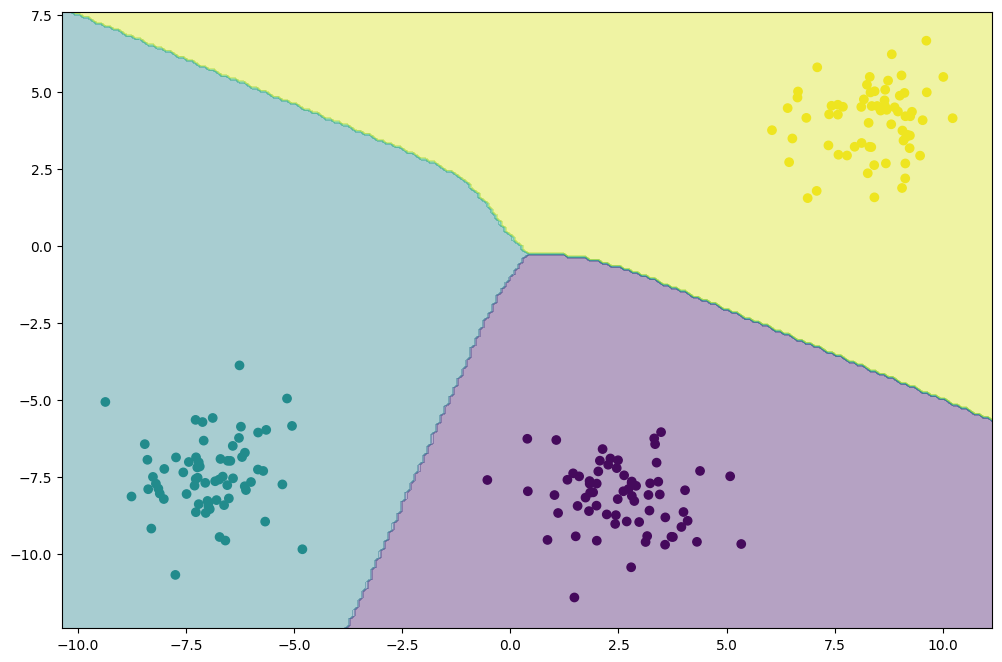

In [8]:
draw_boundary_multiclass(mlp, inputs, labels)

## Pokus na *winequality-white.csv* datasetu

In [9]:
data = pd.read_csv("winequality-white.csv", delimiter=';')
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

In [10]:
data["quality"].replace({3: 5, 4: 5, 8: 7, 9: 7}, inplace=True)
data["quality"].replace({5: 0, 6: 1, 7: 2}, inplace=True)

labels = data["quality"].values
inputs = data.drop(columns="quality").values

In [11]:
mlp = MultiLayerPerceptron([inputs.shape[1], 5, len(np.unique(labels))])

predictions = mlp.predict(inputs)
predicted_classes = np.argmax(predictions, axis=-1)
model_accuracy = accuracy_score(predicted_classes, labels)
print("Accuracy before training:", model_accuracy)

mlp.fit(inputs, labels)

model_accuracy = get_model_accuracy(mlp, inputs, labels)
print("Accuracy after training:", model_accuracy)

Accuracy before training: 0.21641486320947326


Accuracy after iteration 0: 0.44875459371171905:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy after iteration 900: 0.44875459371171905: 100%|██████████| 1000/1000 [00:07<00:00, 128.73it/s]

Accuracy after training: 0.44875459371171905


[[   0    0 1640]
 [   0    0 2198]
 [   0    0 1060]]


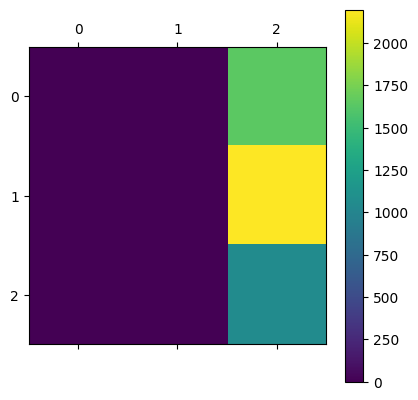

In [12]:
confusion_matrix = metrics.confusion_matrix(labels, predicted_classes)
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()